In [115]:
import numpy as np
import pandas as pd
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [116]:
# ****** Using https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/ as a guide ******

assets = ['BTC-USD','GC=F','^GSPC','^VIX']
timeSeriesData = pd.DataFrame()
for asset in assets:
    timeSeriesData[asset] = wb.DataReader(asset, data_source ='yahoo',start='2014-09-17')['Close']

timeSeriesData.rename(columns={'GC=F': 'Gold-USD Futures', '^GSPC': 'S&P500', '^VIX': 'VIX'}, inplace=True)

timeSeriesData['Expected Inflation'] = wb.DataReader(['T10YIE'], 'fred', '2014-09-17') #10 year break even inflation (10 yr treasury yield - 10 yr TIPS yield)
timeSeriesData['US1Y'] = wb.DataReader(['DGS1'], 'fred', '2014-09-17') #Yield on US Treasury Securities ~ 1 year
timeSeriesData['WTI'] = wb.DataReader(['DCOILWTICO'], 'fred', '2014-09-17') #West Texas Intermediate - Oil Benchmark
timeSeriesData['EPI'] = wb.DataReader(['USEPUINDXD'], 'fred', '2014-09-17') #Economic Policy Uncertainty Index https://www.policyuncertainty.com/methodology.html
timeSeriesData['US Dollar Index'] = wb.DataReader(['DTWEXBGS'], 'fred', '2014-09-17') #Nominal Broad US Dollar Index (trade-weighted)

timeSeriesData = timeSeriesData.dropna()
timeSeriesData


,BTC-USD,Gold-USD Futures,S&P500,VIX,Expected Inflation,US1Y,WTI,EPI,US Dollar Index
Date,,,,,,,,,
2014-09-17,457.334015,1234.400024,2001.569946,12.650000,2.06,0.12,94.33,40.90,95.9103
2014-09-18,424.440002,1225.699951,2011.359985,12.030000,2.02,0.12,93.07,26.32,96.1281
2014-09-19,394.795990,1215.300049,2010.400024,12.110000,2.03,0.11,92.43,31.65,96.3414
2014-09-22,402.152008,1216.800049,1994.290039,13.690000,1.99,0.10,91.46,124.77,96.4622
2014-09-23,435.790985,1221.000000,1982.770020,14.930000,2.02,0.10,91.55,102.33,96.5109
...,...,...,...,...,...,...,...,...,...
2021-11-18,56942.136719,1861.000000,4704.540039,17.590000,2.73,0.18,78.92,142.27,115.4789
2021-11-19,58119.578125,1851.199951,4697.959961,17.910000,2.65,0.18,76.11,125.52,115.6317
2021-11-22,56289.289062,1806.000000,4682.939941,19.170000,2.61,0.20,76.74,92.98,116.0779


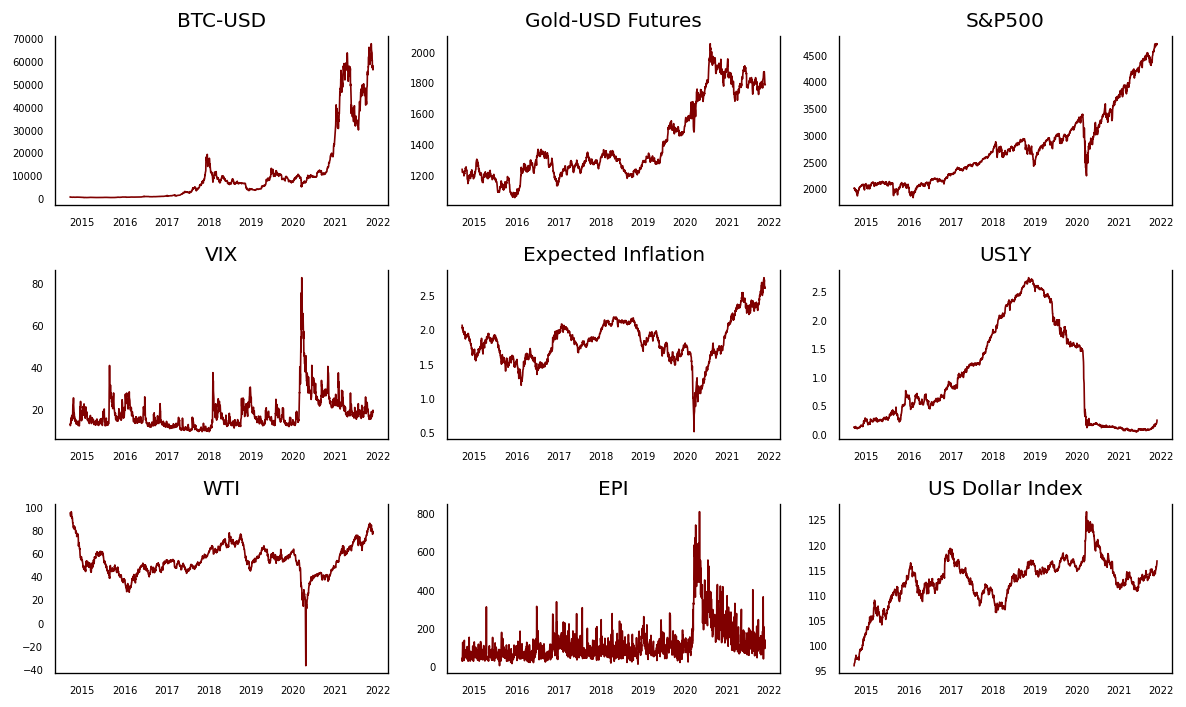

In [117]:
# Plot
fig, axes = plt.subplots(nrows=3, ncols=3, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = timeSeriesData[timeSeriesData.columns[i]]
    ax.plot(data, color='maroon', linewidth=1)
    # Decorations
    ax.set_title(timeSeriesData.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

In [118]:
# Granger's Causality Test
# Values in cells are p-values.
# Null-hypothesis = past values of X do not cause Y
# If p-value is less than alpha = 0.05, reject null-hypothesis and past values of X cause Y, or are at least useful in forecasting Y
# Technically, the null-hypothesis tests that the coefficients of past values in the regression equation are zero
# Using the vector autoregression (VAR) assumes most, if not all, the variables are endogenous, or influence each other
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    alpha = 0.05
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]

    # colors maroon cells that have p-values < 0.05
    df = df.style.apply(lambda x: ["background: green" if v < alpha else "" for v in x], axis = 1)
    
    return df

grangers_causation_matrix(timeSeriesData, variables = timeSeriesData.columns)   

C:\Users\matth\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  warnings.warn('covariance of constraints does not have full '
C:\Users\matth\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  warnings.warn('covariance of constraints does not have full '


,BTC-USD_x,Gold-USD Futures_x,S&P500_x,VIX_x,Expected Inflation_x,US1Y_x,WTI_x,EPI_x,US Dollar Index_x
BTC-USD_y,1.000000,0.037700,0.002100,0.073800,0.475800,0.236200,0.545300,0.047600,0.363200
Gold-USD Futures_y,0.337900,1.000000,0.003500,0.000000,0.000000,0.014900,0.004400,0.000000,0.001900
S&P500_y,0.033100,0.000000,1.000000,0.000000,0.000000,0.000100,0.000300,0.000000,0.000200
VIX_y,0.114700,0.000700,0.000000,1.000000,0.027300,0.000000,0.038500,0.251300,0.018200
Expected Inflation_y,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000500,0.000500,0.002300
US1Y_y,0.804200,0.005900,0.000000,0.000000,0.000600,1.000000,0.039100,0.108000,0.000400
WTI_y,0.000900,0.000000,0.000000,0.000000,0.000000,0.003400,1.000000,0.000100,0.000000
EPI_y,0.001900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
US Dollar Index_y,0.342400,0.000100,0.000000,0.000000,0.000000,0.008400,0.004100,0.242300,1.000000


In [119]:
# Cointegration

# Order of integration(d) is the number of differencing (d) required to make a non-stationary time series stationary
# Non-stationary time series are trending and/or have a changing variance
# Dataset is I(d) if the graph of ((1-L)^d)*y(t) = z(t) is stationary and without trend
# First order difference, i.e. I(1), is z(t) = y(t) - y(t-1)
# Second order difference, i.e. I(2), is z(t) = (y(t) - y(t-1))*(y(t-1))
# z(t) = y-axis

# When a linear combination of 2+ time series has an order of integration(d) less than the individual series, the time series are cointegrated 
# and have a long run, statistically significant relationship
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    df = pd.DataFrame([[adjust(col), adjust(round(trace,2), 9) + ">" + adjust(cvt, 8), trace > cvt] 
    for col, trace, cvt in zip(df.columns, traces, cvts)], columns = ['Name','Test Stat > C(95%)','Significant'])
    
    return df

cointegration_test(timeSeriesData)

,Name,Test Stat > C(95%),Significant
0,BTC-USD,357.08 >179.5199,True
1,Gold-USD Futures,218.49 >143.6691,True
2,S&P500,152.48 >111.7797,True
3,VIX,93.82 >83.9383,True
4,Expected Inflation,54.58 >60.0627,False
5,US1Y,31.98 >40.1749,False
6,WTI,15.59 >24.2761,False
7,EPI,2.92 >12.3212,False
8,US Dollar Index,0.22 >4.1296,False


In [120]:
# Check for stationarity & make time series stationary
# Based function off of https://youtu.be/twHaVc_H7ik , https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/ , 
# and https://www.statology.org/dickey-fuller-test-python/
# adfuller() function is augmented Dicky-Fuller test to test for stationarity
# adfuller(df[column][1]) returns the p-value of the augmented Dickey-Fuller test on the variable
def findDifference(df, alpha=0.05, counter = 0):
    pValList = []
    for column in df.columns:
        pValList.append(adfuller(df[column])[1])
    if all(pValList) < alpha:
        return counter
    else:
        counter += 1
        df = df.diff().dropna()
        return findDifference(df, alpha, counter)

findDifference(timeSeriesData)

grangers_causation_matrix(timeSeriesData.diff().dropna(), variables = timeSeriesData.columns)

,BTC-USD_x,Gold-USD Futures_x,S&P500_x,VIX_x,Expected Inflation_x,US1Y_x,WTI_x,EPI_x,US Dollar Index_x
BTC-USD_y,1.000000,0.145600,0.020900,0.093500,0.235000,0.524400,0.463500,0.137500,0.284700
Gold-USD Futures_y,0.280900,1.000000,0.002100,0.000000,0.000000,0.009000,0.004500,0.001600,0.351600
S&P500_y,0.157300,0.000000,1.000000,0.000000,0.000000,0.000200,0.000200,0.011300,0.000200
VIX_y,0.064700,0.001900,0.000000,1.000000,0.025100,0.000500,0.045400,0.105400,0.003500
Expected Inflation_y,0.000300,0.000000,0.000000,0.000000,1.000000,0.000000,0.000100,0.031200,0.001400
US1Y_y,0.641800,0.104400,0.000000,0.000000,0.028100,1.000000,0.373700,0.754500,0.036900
WTI_y,0.016900,0.000000,0.000000,0.000000,0.000000,0.002800,1.000000,0.000100,0.000000
EPI_y,0.000600,0.014500,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.001000
US Dollar Index_y,0.210000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001400,0.189400,1.000000


In [121]:
# Test to prove that indeed the order of integration is indeed 1 to make the time-series stationary
# Order of difference = I(0)

def checkDifference(df, difference):
    for column in df.columns:
            print(column + ' ', adfuller(df[column])[1])
    for i in range(difference):
        df = df.diff().dropna()
        print('\n')
        for column in df.columns:
            print(column + ' ', adfuller(df[column])[1])
    return

checkDifference(timeSeriesData,1)


BTC-USD  0.9074911357188938
Gold-USD Futures  0.8510695232595454
S&P500  0.9937527779928907
VIX  0.00020077425717273824
Expected Inflation  0.6598349629382171
US1Y  0.7392720323128976
WTI  0.04303091515687553
EPI  0.013708246764941772
US Dollar Index  0.011228499834166529


BTC-USD  1.0170678548660329e-09
Gold-USD Futures  9.518235303340747e-22
S&P500  1.1486279594578805e-24
VIX  1.6594919242319287e-27
Expected Inflation  6.960363129175674e-19
US1Y  5.245618040904515e-11
WTI  4.826197849443462e-13
EPI  9.54583514016159e-29
US Dollar Index  0.0


In [122]:
# Train & test data
dataSize = timeSeriesData.shape[0]
originalTrain = timeSeriesData.iloc[:round(0.8*dataSize)]
train_df = timeSeriesData.iloc[:round(0.8*dataSize)].diff().dropna()
test_df = timeSeriesData.iloc[round(0.8*dataSize):]

# train_df.index = pd.DatetimeIndex(train_df.index).to_period('D')
# Look for correct amount of lags for model, i.e. past values that can be used to predict current values (autoregressive models)
# AIC = Akaike Information Criterion
def findVarLagAIC(train_df, maxLags = 10, informationCriterion = 'aic'):
    model = VAR(train_df)
    orderLagDict = {}
    resultsArray = []
    for i in range(1, maxLags + 1):
        results = model.fit(i)
        print(f"Order: {i}, {informationCriterion}: {getattr(results, informationCriterion)}")
        resultsArray.append(getattr(results, informationCriterion))
        orderLagDict[getattr(results, informationCriterion)] = i
    return orderLagDict[min(resultsArray)]

# print(findVarLagAIC(train_df, 50))

# Optimal lag is 19 

model = VAR(train_df)
x = model.select_order(maxlags=50)
# print(x)
# Selected orders are: AIC -> 25, BIC -> 1, FPE -> 19, HQIC ->  3>

results = model.fit(19)
results.summary()
# print(results.plot())


C:\Users\matth\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 01, Dec, 2021
Time:                     17:48:59
--------------------------------------------------------------------
No. of Equations:         9.00000    BIC:                    20.8219
Nobs:                     1398.00    HQIC:                   17.1868
Log likelihood:          -26801.6    FPE:                3.36119e+06
AIC:                      15.0165    Det(Omega_mle):     1.18293e+06
--------------------------------------------------------------------
Results for equation BTC-USD
                            coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------
const                          5.247658        10.218859            0.514           0.608
L1.BTC-USD                    -0.009162         0.029009           -0.316           0.752
L1.Gold-USD Futures   

In [123]:
# Check for serial correlation of residuals (errors) using Durbin Watson Statistic
# If there is any correlation left in the residuals, then, there is some pattern in the time series that is still left to be explained by the model.
# The closer it is to the value 2, then there is no significant serial correlation.
# All values are around 2
from statsmodels.stats.stattools import durbin_watson

def findSerialCorrelation(originalDataframe, fittedModelResults):
    out = durbin_watson(getattr(fittedModelResults, "resid"))

    def adjust(val, length= 6): return str(val).ljust(length)

    for col, val in zip(getattr(originalDataframe, "columns"), out):
        print(adjust(col), ':', round(val, 2))

print(findSerialCorrelation(train_df, results))

BTC-USD : 2.01
Gold-USD Futures : 2.01
S&P500 : 2.0
VIX    : 2.0
Expected Inflation : 1.99
US1Y   : 2.0
WTI    : 1.94
EPI    : 2.0
US Dollar Index : 2.0
None


In [124]:
# Forecast VAR model
# In order to forecast, the VAR model expects up to the lag order number of observations from the past data. 
# This is because, the terms in the VAR model are essentially the lags of the various time series in the dataset,
# so you need to provide it as many of the previous values as indicated by the lag order used by the model.

lag_order = results.k_ar
# print(lag_order)

forecast_input = train_df.values[-lag_order:]
# print(forecast_input)

numberOfObservations = dataSize - round(0.8*dataSize)

forecast = results.forecast(y=forecast_input, steps=numberOfObservations)
df_forecast = pd.DataFrame(forecast, index=timeSeriesData.index[-numberOfObservations:], columns=timeSeriesData.columns + '_1d')
print(df_forecast)

            BTC-USD_1d  Gold-USD Futures_1d  S&P500_1d    VIX_1d  \
Date                                                               
2020-06-19 -103.611451             3.479658  27.891416 -1.256354   
2020-06-22   96.989894            -1.420188 -45.085346  1.412491   
2020-06-23  385.286459            12.442254  36.983470 -1.751750   
2020-06-24  -92.814437           -12.357203 -48.114984  1.690923   
2020-06-25  -59.858103             9.606981  17.477272 -1.267696   
...                ...                  ...        ...       ...   
2021-11-18    6.350661             0.336700   0.883523  0.010008   
2021-11-19    6.350663             0.336700   0.883522  0.010008   
2021-11-22    6.350662             0.336700   0.883523  0.010008   
2021-11-23    6.350666             0.336700   0.883523  0.010008   
2021-11-24    6.350662             0.336700   0.883523  0.010008   

            Expected Inflation_1d   US1Y_1d    WTI_1d     EPI_1d  \
Date                                           

In [125]:
def invert_transformation(train_df, df_forecast):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = getattr(train_df, "columns")
    
    for col in columns:        
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = train_df[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

df_results = invert_transformation(originalTrain, df_forecast)
print(df_results)

            BTC-USD_1d  Gold-USD Futures_1d  S&P500_1d    VIX_1d  \
Date                                                               
2020-06-19 -103.611451             3.479658  27.891416 -1.256354   
2020-06-22   96.989894            -1.420188 -45.085346  1.412491   
2020-06-23  385.286459            12.442254  36.983470 -1.751750   
2020-06-24  -92.814437           -12.357203 -48.114984  1.690923   
2020-06-25  -59.858103             9.606981  17.477272 -1.267696   
...                ...                  ...        ...       ...   
2021-11-18    6.350661             0.336700   0.883523  0.010008   
2021-11-19    6.350663             0.336700   0.883522  0.010008   
2021-11-22    6.350662             0.336700   0.883523  0.010008   
2021-11-23    6.350666             0.336700   0.883523  0.010008   
2021-11-24    6.350662             0.336700   0.883523  0.010008   

            Expected Inflation_1d   US1Y_1d    WTI_1d     EPI_1d  \
Date                                           

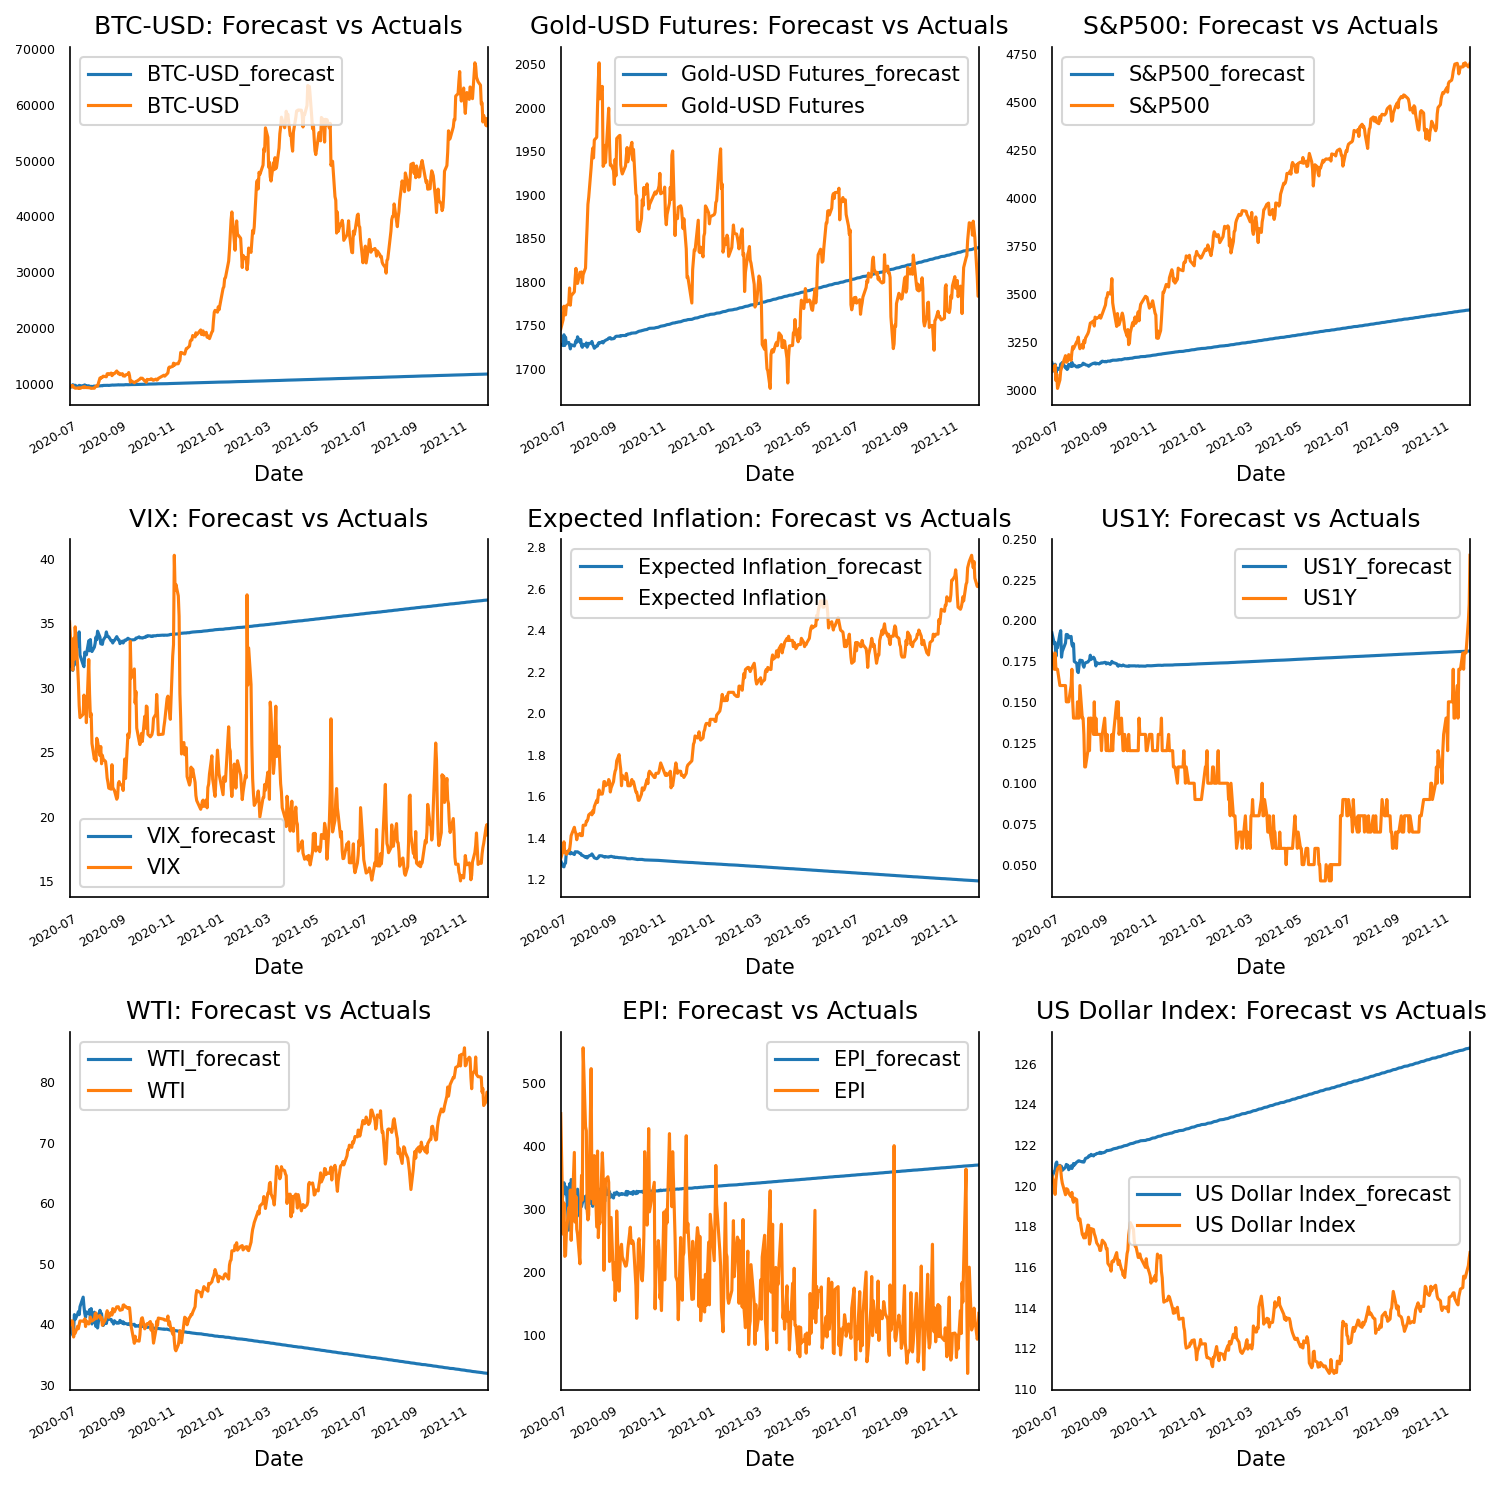

In [127]:

fig, axes = plt.subplots(nrows=3, ncols=3, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(timeSeriesData.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True) #here
    test_df[col][-numberOfObservations:].plot(legend=True, ax=ax)
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

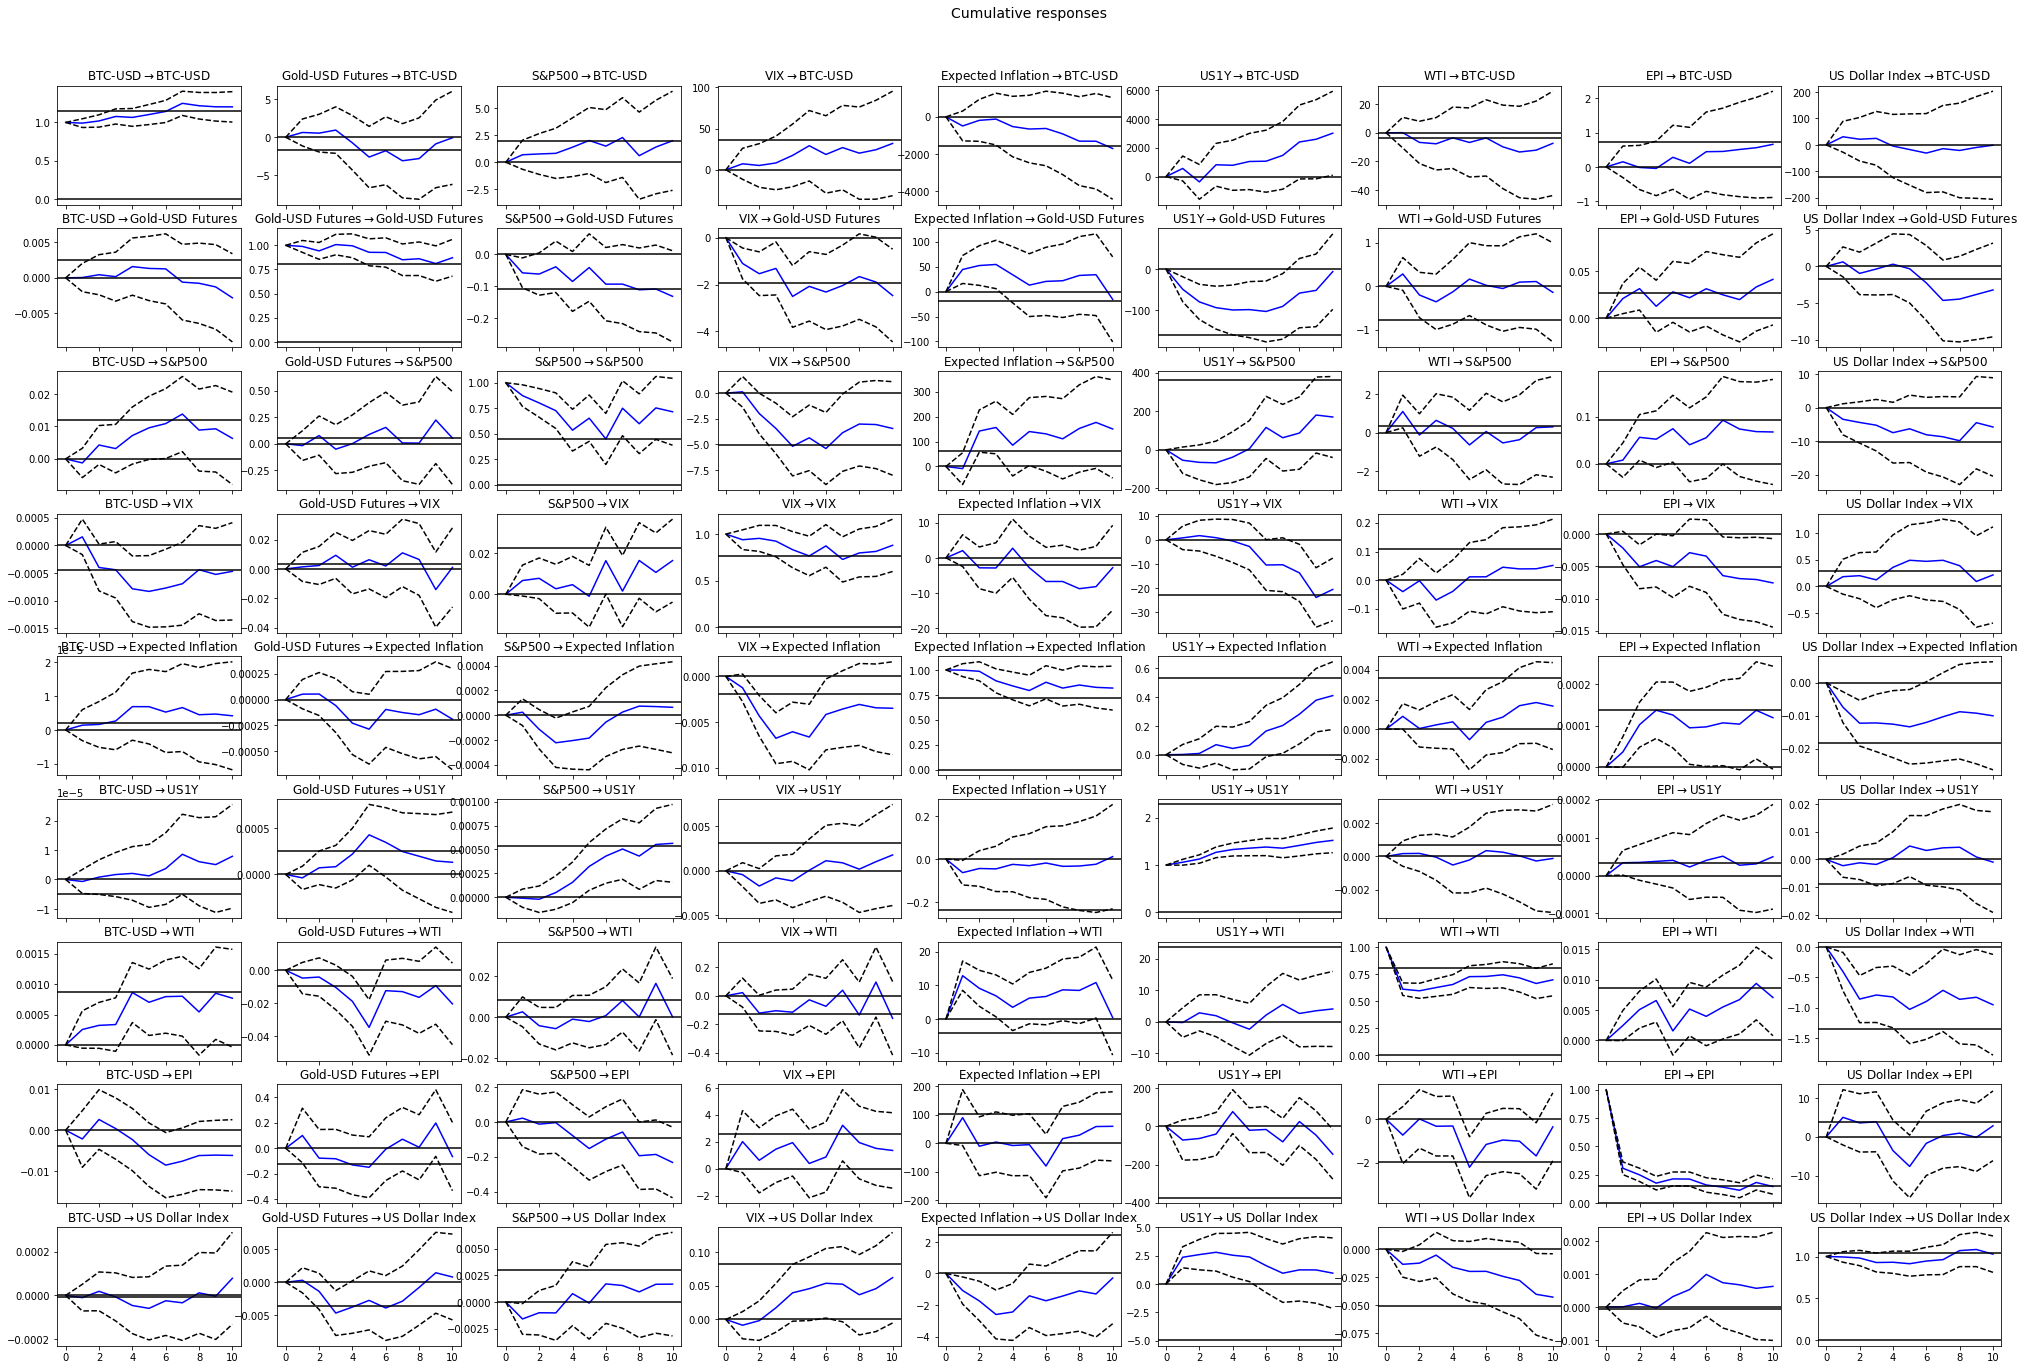

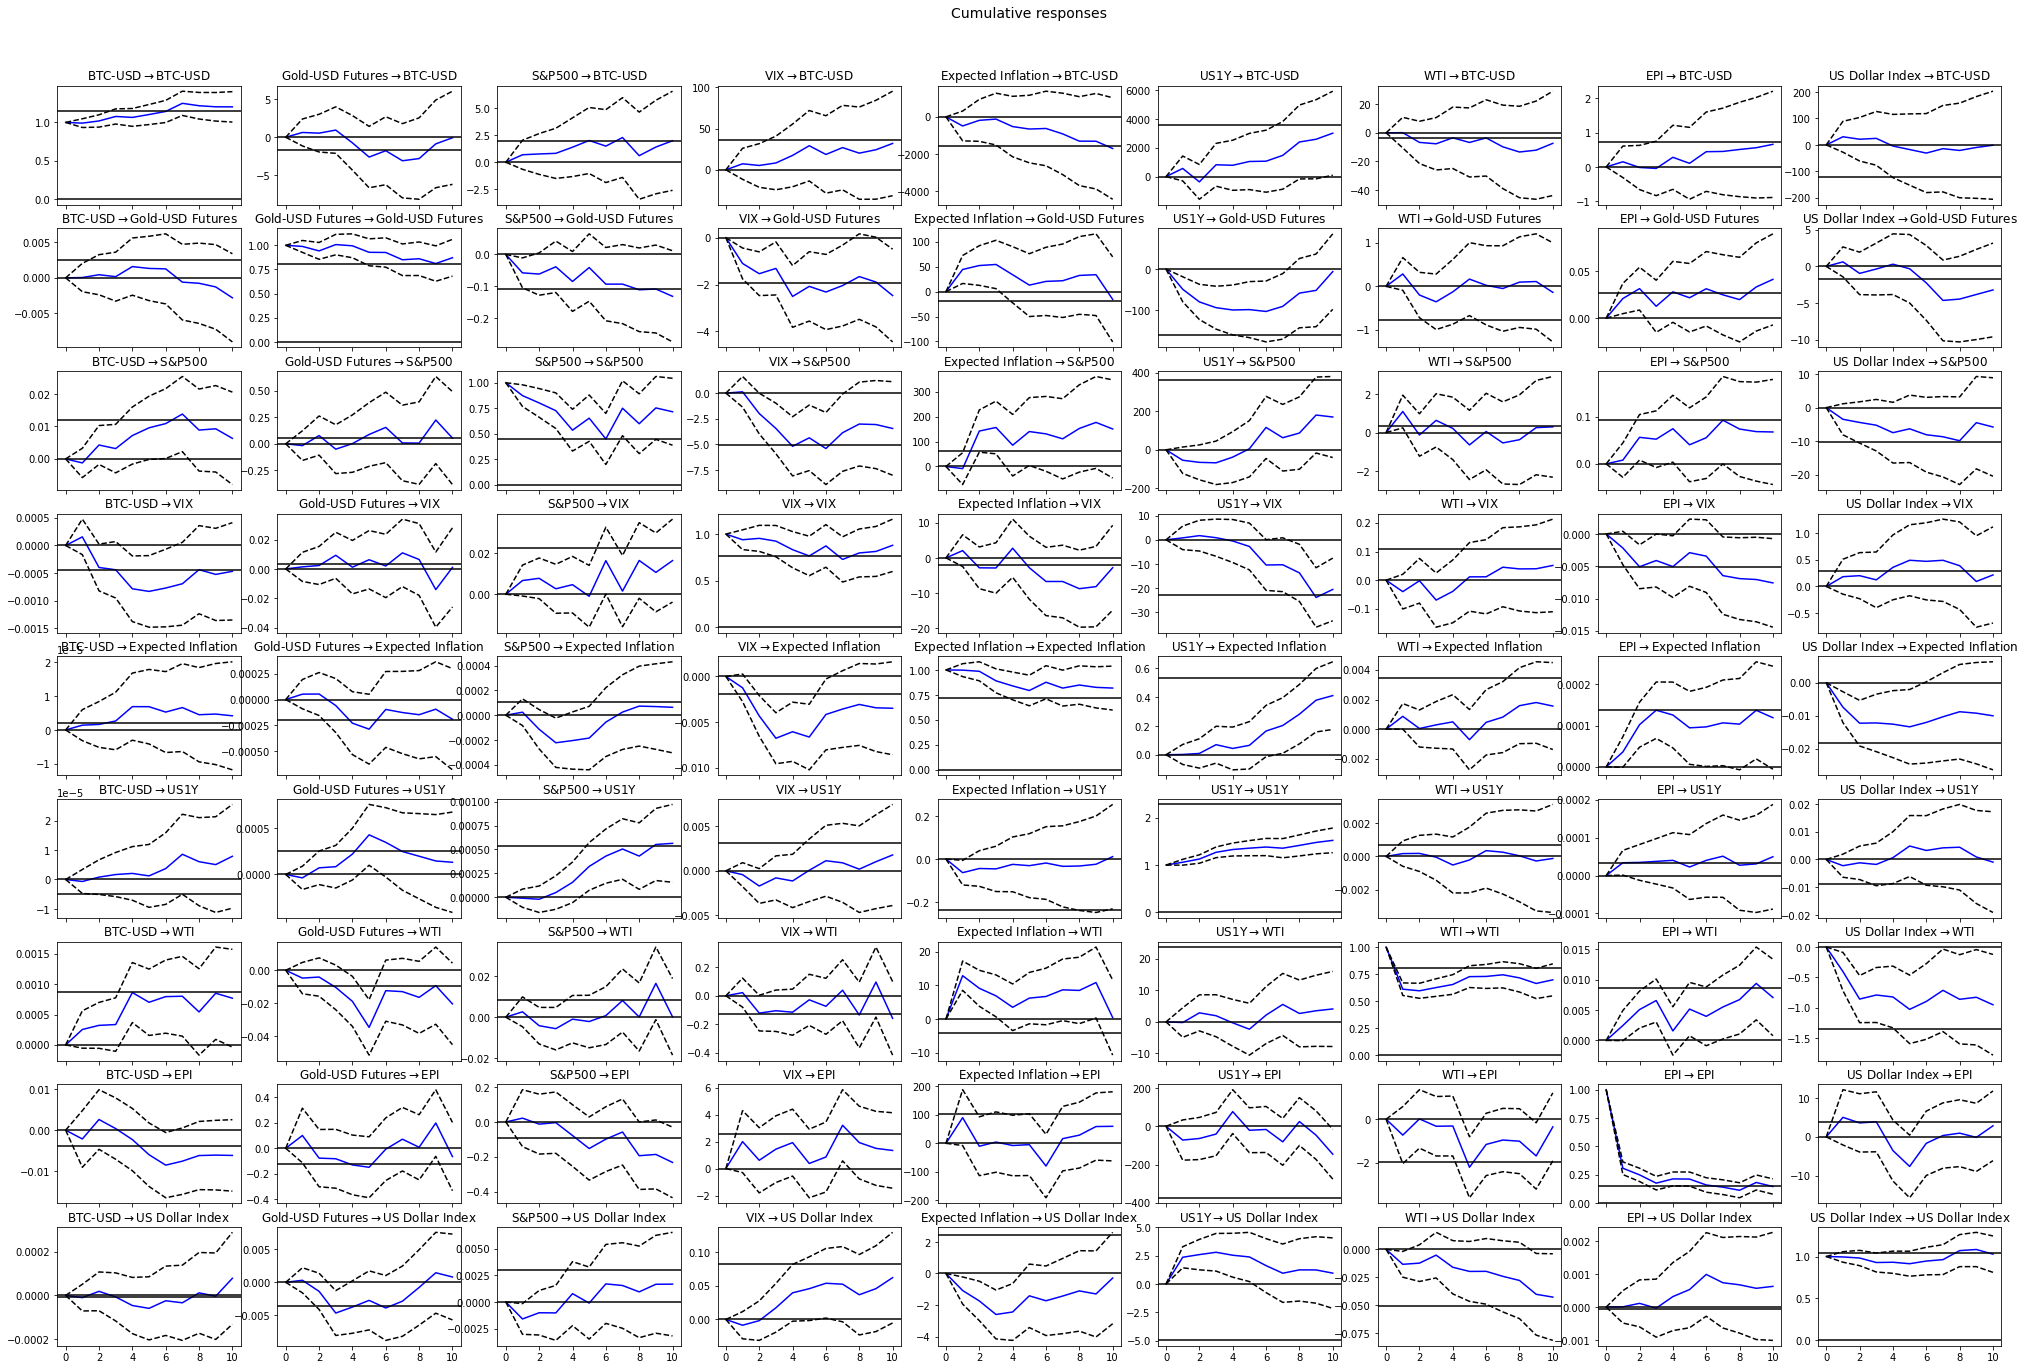

In [136]:
# Impulse response?
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.vector_ar.irf.IRAnalysis.plot.html
# https://www.statsmodels.org/stable/vector_ar.html
# use website above to format?
# first variable is impulse, second variable is the response
# https://www.aptech.com/blog/the-intuition-behind-impulse-response-functions-and-forecast-error-variance-decomposition/
# ^ explains impulse response models
# X-axis = time periods
# Y-axis = response variable (second variable)
# purpose: find out how Y response variable responds to a 1 SD shock in the impulse variable

irf = results.irf(10)
# irf.plot(orth=False, figsize=(30,20))
irf.plot_cum_effects(orth=False, figsize=(30,20))